## Quantum energy teleportation protocol to storage energy

### Import packages

In [2]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit import transpile

from qiskit_aer import AerSimulator
from qiskit_aer.primitives import SamplerV2 as sampler
from qiskit.visualization import plot_histogram

In [ ]:
from qiskit.quantum_info import Statevector, Operator

# Parameters
h_A = 1; h_B = 0.01; h_C = 0.786; k = 0.393; 

# Basis
ket_0 = np.array([[1],[0]])
ket_1 = np.array([[0],[1]])
ket_00 = np.kron(ket_0,ket_0)
ket_11 = np.kron(ket_1,ket_1)

# Operators
I = Operator.from_label('III').to_matrix()
Z_A = Operator.from_label('IIZ').to_matrix(); Z_B = Operator.from_label('IZI').to_matrix(); Z_C = Operator.from_label('ZII').to_matrix()
X_AB = Operator.from_label('IXX').to_matrix(); X_A = Operator.from_label('IIX').to_matrix()
Y_B = Operator.from_label('IYI').to_matrix(); Y_C = Operator.from_label('YII').to_matrix()

# Ground state
theta = np.arctan(np.sqrt((h_A/(2*k) + h_B/(2*k))**2+1)-(h_A/(2*k) + h_B/(2*k)))

qet_g = np.cos(theta)*ket_00 - np.sin(theta)*ket_11
ket_g = np.kron(ket_0,qet_g)
state_g = Statevector(ket_g)
display('Ground State:', state_g.draw('latex'))

# Hamiltonians
alpha = 2*k/(np.sqrt((h_A + h_B)**2+4*k**2) + h_A + h_B)

H_A = -h_A * Z_A - h_A *(alpha**2-1)/(alpha**2+1) * I
H_B = -h_B * Z_B - h_B*(alpha**2-1)/(alpha**2+1) * I
H_C = -h_C * Z_C + h_C * I
V = 2*k * X_AB + 4*k*alpha/(alpha**2+1) * I

# Define angle phi
phi = np.arctan(np.sqrt((h_B/(2*k))**2+1)-h_B/(2*k)) - theta

# Define operations
def P_A(mi):
    """Measurement of qubit A"""
    return 1/2 * (I + mi * X_A)

def Ry_B(mi):
    """Rotation around Y axis for qubit B"""
    return np.cos(phi) * I - 1j*mi*np.sin(phi) * Y_B

def Ry_C(mi):
    """Rotation around Y axis for qubit C"""
    return np.cos(phi) * I - 1j*mi*np.sin(phi) * Y_C

def Ry_pi():
    """Rotation of pi around Y axis for qubit C"""
    return np.cos(np.pi/2) * I - 1j*np.sin(np.pi/2) * Y_C

# Final State Density Matrix
P_QET = np.zeros((8, 8), dtype=complex)
for mi in [-1, 1]:
    P_QET = P_QET + Ry_C(-mi) @ Ry_B(-mi) @  Ry_C(mi) @ Ry_pi() @P_A(mi) @ (ket_g@ket_g.conj().T) @ P_A(mi) @ Ry_pi().conj().T @ Ry_C(mi).conj().T  @ Ry_B(-mi).conj().T @ Ry_C(-mi).conj().T
display(Operator(P_QET).draw('latex'))

# Energies
E_Ha = np.trace(P_QET@H_A).real
E_Hb = np.trace(P_QET@H_B).real
E_Hc = np.trace(P_QET@H_C).real
E_V = np.trace(P_QET@V).real
E_A = np.trace(P_QET@(H_A+V)).real
E_B = np.trace(P_QET@(H_B+V)).real 

# Print results
print(f"""
Ground State Energies:
<H_A> = {ket_g.T@H_A@ket_g}
<H_B> = {ket_g.T@H_B@ket_g}
<V> = {ket_g.T@V@ket_g}
            
Final Energies:
H_A = {E_Ha},
H_B = {E_Hb},
H_C = {E_Hc},
V = {E_V},
E_A = {E_A},
E_B = {E_B}
""")

'Ground State:'

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>


Ground State Energies:
<H_A> = [[-8.32667268e-17+0.j]]
<H_B> = [[-1.51788304e-18+0.j]]
<V> = [[0.+0.j]]
            
Final Energies:
H_A = 0.7891838926010616,
H_B = 0.007764622758458546,
H_C = 1.572,
V = -0.30320901615994295,
E_A = 0.48597487644111864,
E_B = -0.2954443934014844



### Function to generate a circuit that measures the local term $Z$ or $H$

In [74]:
def qc_H(h_A,h_B,k):
    qc = QuantumCircuit(3)

    # Prepare ground state
    theta = np.arctan(np.sqrt((h_A/(2*k) + h_B/(2*k))**2+1)-(h_A/(2*k) + h_B/(2*k)))
                  
    qc.ry(-2*theta,0)
    qc.cx(0,1)
    qc.barrier()

    # Alice's projective measurement
    qc.h(0)
    qc.barrier()

    # Charlie prepare qubit C
    phi = np.arctan(np.sqrt((h_B/(2*k))**2+1)-h_B/(2*k)) - theta

    qc.cry(np.pi - 2*phi,0,2)

    qc.x(0)
    qc.cry(np.pi + 2*phi,0,2)
    qc.x(0)
    qc.barrier()

    #Bob's conditional operation
    qc.cry(2*phi,0,1)
    qc.cry(2*phi,0,2)
    
    qc.x(0)
    qc.cry(-2*phi,0,1)
    qc.cry(-2*phi,0,2)
    qc.x(0)

    # measurament of qubit B and C
    qc.measure_all()

    return qc

### Function to generate a circuit that measures the interaction term $X_0X_1$ or $V$

In [75]:
def qc_V(h_A,h_B,k):
    qc = QuantumCircuit(3)

    # Prepare ground state
    theta = np.arctan(np.sqrt((h_A/(2*k) + h_B/(2*k))**2+1)-(h_A/(2*k) + h_B/(2*k)))
                  
    qc.ry(-2*theta,0)
    qc.cx(0,1)
    qc.barrier()

    # Alice's projective measurement
    qc.h(0)
    qc.barrier()

    # Charlie prepare qubit C
    phi = np.arctan(np.sqrt((h_B/(2*k))**2+1)-h_B/(2*k)) - theta

    qc.cry(np.pi - 2*phi,0,2)

    qc.x(0)
    qc.cry(np.pi + 2*phi,0,2)
    qc.x(0)
    qc.barrier()

    #Bob's conditional operation
    qc.cry(2*phi,0,1)
    qc.cry(2*phi,0,2)

    
    qc.x(0)
    qc.cry(-2*phi,0,1)
    qc.cry(-2*phi,0,2)
    qc.x(0)

    # measurament of qubit B and C
    qc.h(1)
    qc.measure_all()

    return qc

### Show quantum circuit

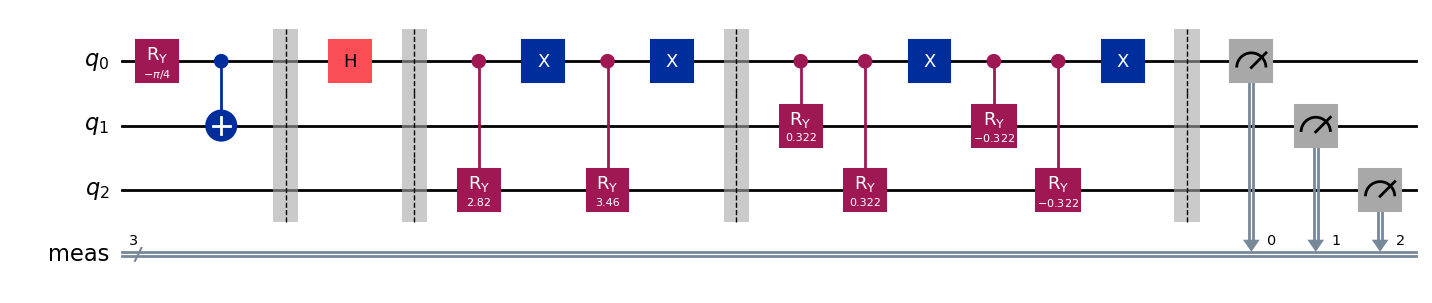

In [76]:
qc = qc_H(1,1,1)
qc.draw('mpl')

### Simulate circuit $H$ with aer simulator

In [77]:
# Initiate simulator
simulator = AerSimulator()

# Parameters
h_A = 1;h_B = 0.01; k = 0.393;
n_shots = 1000

# Generate circuit
qc = qc_H(h_A,h_B,k)
qc_B = transpile(qc, simulator, optimization_level=3)

# Run job with Sampler
jobB_sim = sampler().run([qc_B], shots=n_shots)

### Simulate circuit $V$ with aer simulator

In [78]:
# Initiate simulator
simulator = AerSimulator()

# Parameters
h_A = 1;h_B = 0.01; k = 0.393;
n_shots = 1000

# Generate circuit
qc = qc_V(h_A,h_B,k)
qc_A = transpile(qc, simulator, optimization_level=3)

# Run job with Sampler
jobA_sim = sampler().run([qc_A], shots=n_shots)

### Show Results for simulated circuit $H$

Alice's local energy =  0.8131838926010617 ± 0.031613667930184886
H_B =  0.007631838926010617 ± 0.00031612086296225377
H_C =  1.572 ± 7.021666937153402e-18


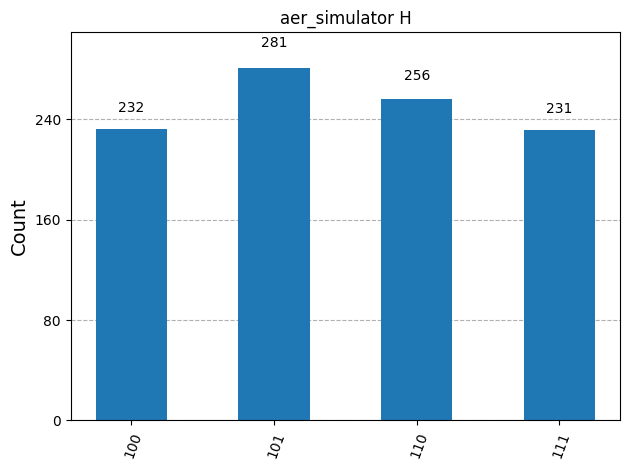

In [79]:
result = jobB_sim.result()[0]
counts = result.data.meas.get_counts()

h_C = 0.786
alpha = 2*k/(np.sqrt((h_A + h_B)**2+4*k**2) + h_A + h_B)
f_i = (alpha**2-1)/(alpha**2+1)
ene_A = -h_A*f_i
ene_B = -h_B*f_i
ene_C = h_C

error_A = []
error_B = []
error_C = []
for orig_bit_string, count in counts.items():
        bit_string = orig_bit_string[::-1]

        ene_A += -h_A*(-1)**int(bit_string[0])*count/n_shots
        ene_B += -h_B*(-1)**int(bit_string[1])*count/n_shots      
        ene_C += -h_C*(-1)**int(bit_string[2])*count/n_shots

        for i in range(count):
            error_A.append(-h_A*(-1)**int(bit_string[0]))
            error_B.append(-h_B*(-1)**int(bit_string[1]))
            error_C.append(-0.786*(-1)**int(bit_string[2]))

print("Alice's local energy = ",ene_A,"±",np.std(error_A)/np.sqrt(n_shots))
print("H_B = ",ene_B,"±",np.std(error_B)/np.sqrt(n_shots))
print("H_C = ",ene_C,"±",np.std(error_C)/np.sqrt(n_shots))

plot_histogram(counts, title="aer_simulator H")

### Show results for simulated circuit $V$

Interacting energy, V =  -0.3032726216699351 ± 0.02481649837797428


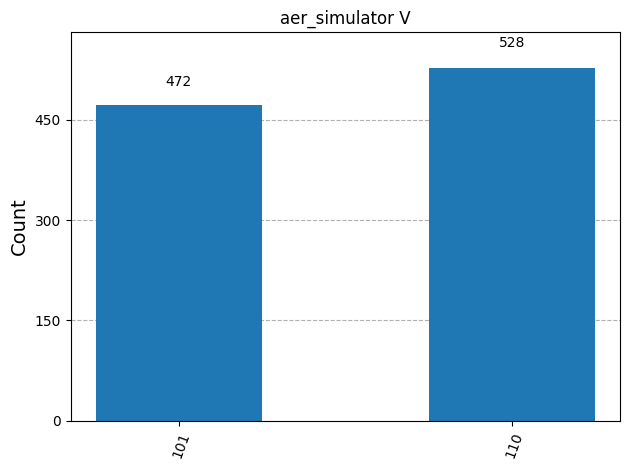

In [80]:
result = jobA_sim.result()[0]
counts = result.data.meas.get_counts()

alpha = 2*k/(np.sqrt((h_A + h_B)**2+4*k**2) + h_A + h_B)
ene_V = 4*k*alpha/(alpha**2+1)

error_V = []
for orig_bit_string, count in counts.items():
        bit_string = orig_bit_string[::-1]

        ene_V += 2*k*(-1)**int(bit_string[0])*(-1)**int(bit_string[1])*count/n_shots

        for i in range(count):
            error_V.append(2*k*(-1)**(int(bit_string[1])))

print("Interacting energy, V = ",ene_V,"±",np.std(error_V)/np.sqrt(n_shots))

plot_histogram(counts, title='aer_simulator V')